<a href="https://colab.research.google.com/github/mitkrieg/citibike-timeseries/blob/main/fbprophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pandas as pd
from fbprophet import Prophet
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Flatiron/Capstone/data

Mounted at /gdrive
/gdrive/MyDrive/Flatiron/Capstone/data


In [4]:
%cd ..
% ls

/gdrive/MyDrive/Flatiron/Capstone
cleaning.py  fbprophet_model.ipynb  __pycache__/   trips.pickle
data/        historical.pickle      starts.pickle
ends.pickle  live.pickle            station.py


In [5]:
df = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/data/train_ts.pickle','rb'))
df_test = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/data/test_ts.pickle','rb'))

In [6]:
df

,ds,y
0,2018-06-17 00:00:00,5.0
1,2018-06-17 01:00:00,3.5
2,2018-06-17 02:00:00,3.0
3,2018-06-17 03:00:00,2.0
4,2018-06-17 04:00:00,2.0
...,...,...
331,2018-06-30 19:00:00,14.0
332,2018-06-30 20:00:00,3.0
333,2018-06-30 21:00:00,9.5
334,2018-06-30 22:00:00,10.0


In [7]:
df_test

,ds,y
0,2018-06-18 00:00:00,2.5
1,2018-06-18 01:00:00,1.0
2,2018-06-18 02:00:00,12.0
3,2018-06-18 03:00:00,11.5
4,2018-06-18 04:00:00,11.0
...,...,...
643,2018-07-14 19:00:00,1.0
644,2018-07-14 20:00:00,3.0
645,2018-07-14 21:00:00,4.5
646,2018-07-14 22:00:00,2.5


In [8]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods = 14*24, freq='H')
future

,ds
0,2018-06-17 00:00:00
1,2018-06-17 01:00:00
2,2018-06-17 02:00:00
3,2018-06-17 03:00:00
4,2018-06-17 04:00:00
...,...
667,2018-07-14 19:00:00
668,2018-07-14 20:00:00
669,2018-07-14 21:00:00
670,2018-07-14 22:00:00


In [10]:
forcast = m.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-06-17 00:00:00,9.404598,3.790605,15.193310
1,2018-06-17 01:00:00,9.153126,3.490354,14.989095
2,2018-06-17 02:00:00,9.186885,2.899667,14.817554
3,2018-06-17 03:00:00,9.604113,4.002897,15.764943
4,2018-06-17 04:00:00,9.981806,4.391772,16.117484
...,...,...,...,...
667,2018-07-14 19:00:00,22.168310,15.974026,28.392336
668,2018-07-14 20:00:00,23.757203,17.549840,29.911090
669,2018-07-14 21:00:00,24.453819,18.759717,30.280721
670,2018-07-14 22:00:00,24.632130,18.482055,30.664269


In [11]:
train_ts = df.set_index('ds')
forcast_ts = forcast.set_index('ds')
test_ts = df_test.set_index('ds')

In [12]:
forcast_ts.yhat_upper.sort_values()

ds
2018-06-17 11:00:00     1.930426
2018-06-17 10:00:00     2.225372
2018-06-17 09:00:00     2.653278
2018-06-17 12:00:00     2.689986
2018-06-17 14:00:00     2.955018
                         ...    
2018-07-12 21:00:00    35.259702
2018-07-12 02:00:00    35.304505
2018-07-12 03:00:00    35.548207
2018-07-12 05:00:00    35.963678
2018-07-12 04:00:00    36.284356
Name: yhat_upper, Length: 672, dtype: float64

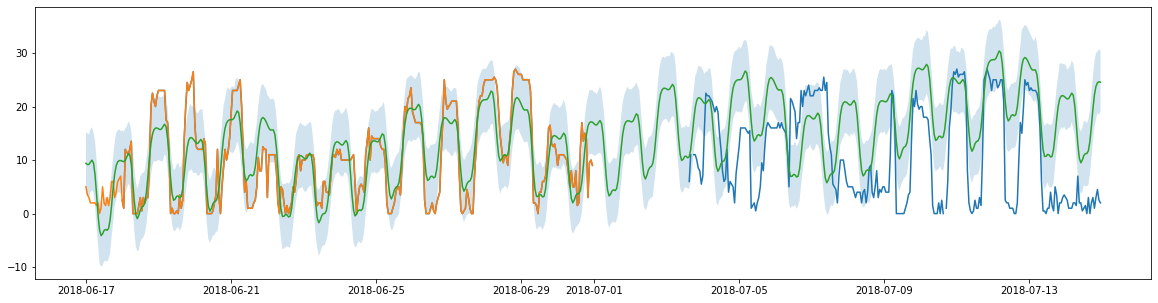

In [13]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
ax.plot(test_ts,label='test')
ax.plot(train_ts,label='train')
ax.plot(forcast_ts.yhat,label='forcast')
ax.fill_between(forcast_ts.index,forcast_ts.yhat_lower,forcast_ts.yhat_upper,alpha=0.2)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
train_rmse = mean_squared_error(y_true=train_ts,
                   y_pred=forcast_ts.yhat[:'2018-06-30'],
                   squared=False)

test_rmse = mean_squared_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
                               y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
                               squared=False)

train_mae = mean_absolute_error(y_true=train_ts,
                   y_pred=forcast_ts.yhat[:'2018-06-30'])

test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
                               y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE:  {test_mae}')

Train RMSE: 4.642565388704062
Train MAE:  3.8067613835242335

Test RMSE: 11.15830362713161
Test MAE:  9.654498200331382


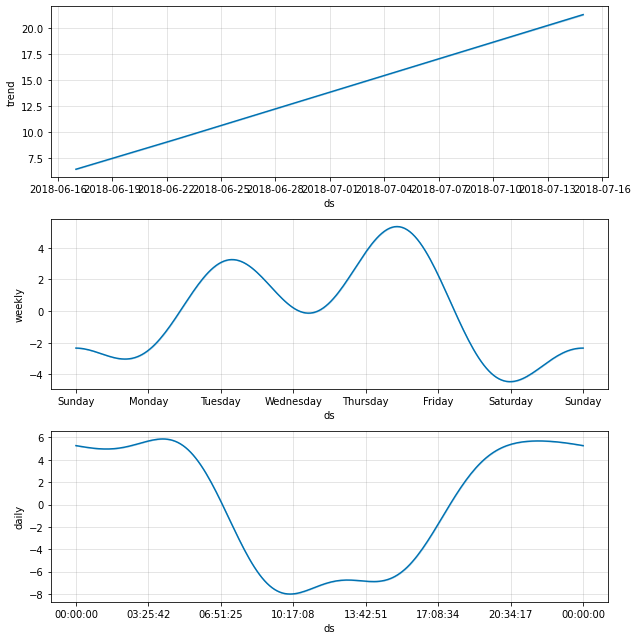

In [16]:
m.plot_components(forcast);

In [17]:
from fbprophet.diagnostics import performance_metrics, cross_validation
from station import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [17]:
year_2018 = pickle.load(open('historical.pickle','rb'))

In [18]:
search_station_id('Amsterdam')

NameError: ignored

In [60]:
station_3176 = year_2018.loc[3167]['2018-02-01':]

In [61]:
station_3176.head()

,station_name,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key,percent_full,season
date_time,,,,,,,,,,
2018-02-01 00:05:00,Amsterdam Ave & W 73 St,27,11,55,40.779668,-73.98093,1,1,0.490909,winter
2018-02-01 00:39:00,Amsterdam Ave & W 73 St,28,10,55,40.779668,-73.98093,1,1,0.509091,winter
2018-02-01 01:11:00,Amsterdam Ave & W 73 St,28,10,55,40.779668,-73.98093,1,1,0.509091,winter
2018-02-01 01:47:00,Amsterdam Ave & W 73 St,28,10,55,40.779668,-73.98093,1,1,0.509091,winter
2018-02-01 02:19:00,Amsterdam Ave & W 73 St,28,10,55,40.779668,-73.98093,1,1,0.509091,winter


In [101]:
availbikes = station_3176.reset_index()[['date_time','avail_bikes']]
availbikes.rename(columns={'date_time':'ds','avail_bikes':'y'}, inplace=True)
availbikes['cap'] = [55 for i in range(len(availbikes))]
availbikes['floor'] = [0 for i in range(len(availbikes))]
availbikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10089 entries, 0 to 10088
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      10089 non-null  datetime64[ns]
 1   y       10089 non-null  int64         
 2   cap     10089 non-null  int64         
 3   floor   10089 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 315.4 KB


In [115]:
year_model = Prophet(growth= 'logistic',yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,
                     seasonality_prior_scale=20,n_changepoints=365)
year_model.fit(availbikes)

In [116]:
future = year_model.make_future_dataframe(periods = 24*119,freq='H')
future['cap'] = [55 for i in range(len(future))]
future['floor'] = [0 for i in range(len(future))]
forcast = year_model.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-02-01 00:05:00,24.392629,13.233565,35.701652
1,2018-02-01 00:39:00,24.462403,13.535391,36.035476
2,2018-02-01 01:11:00,24.642513,12.615410,35.475565
3,2018-02-01 01:47:00,24.924976,13.197293,37.379082
4,2018-02-01 02:19:00,25.220362,13.898068,37.117720
...,...,...,...,...
12940,2019-04-29 19:30:00,10.206412,-1.060001,21.581347
12941,2019-04-29 20:30:00,11.237462,-0.185416,22.442826
12942,2019-04-29 21:30:00,10.784775,-0.407234,22.458139
12943,2019-04-29 22:30:00,9.793419,-2.673258,21.454974


In [117]:
forcast_year_ts = forcast.set_index('ds')
true_year_ts = availbikes.set_index('ds')

(736862.0, 736889.0, -5.0, 45.0)

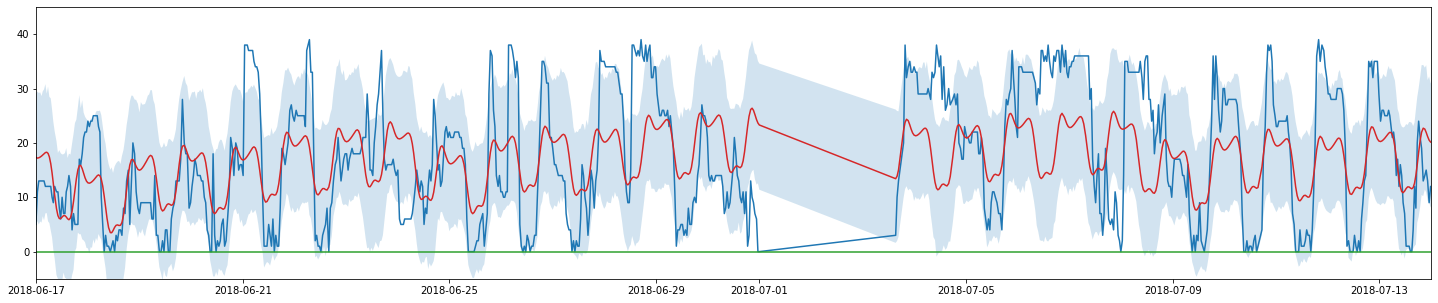

In [118]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
#ax.plot(test_ts,label='test')
ax.plot(true_year_ts,label='train')
ax.plot(forcast_year_ts.yhat,label='forcast')
ax.fill_between(forcast_year_ts.index,forcast_year_ts.yhat_lower,forcast_year_ts.yhat_upper,alpha=0.2)
plt.axis([np.datetime64('2018-06-17'),np.datetime64('2018-07-14'),-5,45])

In [121]:
train_rmse = mean_squared_error(y_true=true_year_ts.y,
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],
                   squared=False)

# test_rmse = mean_squared_error(y_true=true_year_ts.interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
#                                squared=False)

train_mae = mean_absolute_error(y_true=true_year_ts.y,
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],)

# test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

# print(f'Test RMSE: {test_rmse}')
# print(f'Test MAE:  {test_mae}')

Train RMSE: 9.185730707708089
Train MAE:  7.456947625128309



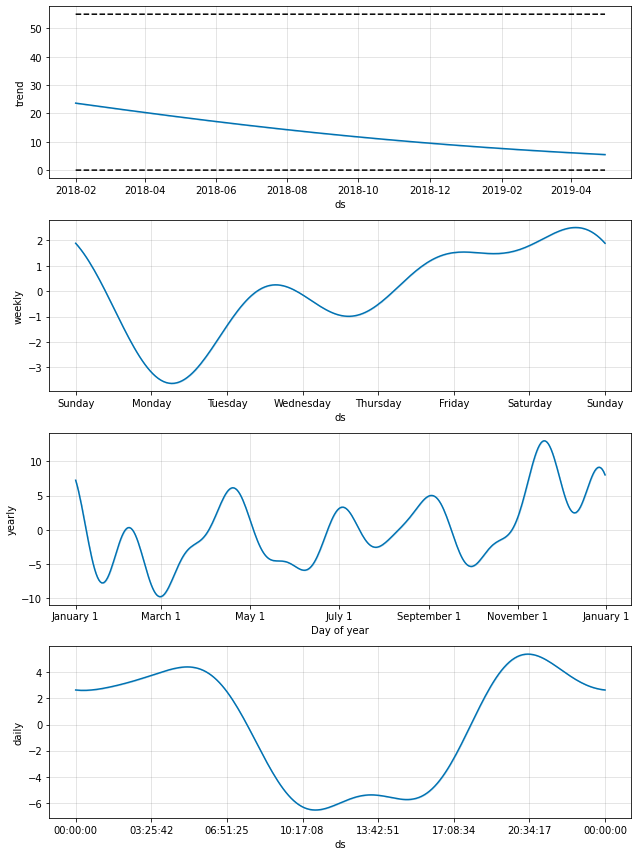

In [107]:
year_model.plot_components(forcast);

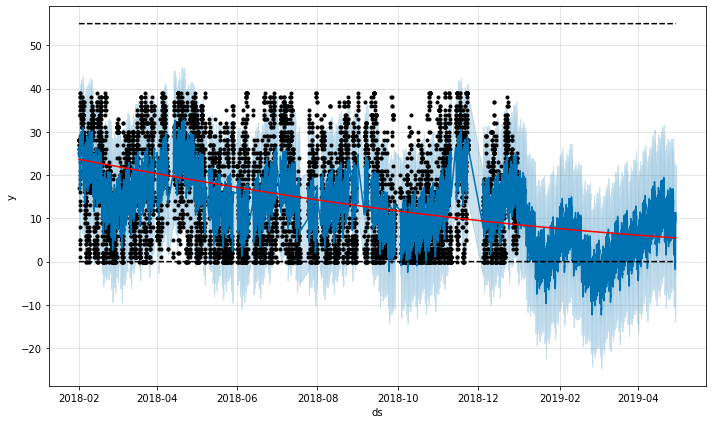

In [108]:
from fbprophet.plot import add_changepoints_to_plot
fig = year_model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), m, forcast)

In [129]:
decomp_prophet = Prophet(growth='logistic')
decomp_prophet.add_seasonality(name='daily',period=1,fourier_order=4, prior_scale=500)
decomp_prophet.add_seasonality(name='weekly',period=7,fourier_order=37, prior_scale=10)
decomp_prophet.fit(availbikes)

future = decomp_prophet.make_future_dataframe(periods = 24*119,freq='H')
future['cap'] = [55 for i in range(len(future))]
future['floor'] = [0 for i in range(len(future))]
forcast = decomp_prophet.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


,ds,yhat,yhat_lower,yhat_upper
0,2018-02-01 00:05:00,23.182884,11.164995,34.384797
1,2018-02-01 00:39:00,24.062189,11.599482,35.285947
2,2018-02-01 01:11:00,24.931790,13.149601,37.079568
3,2018-02-01 01:47:00,25.737523,14.050986,37.765444
4,2018-02-01 02:19:00,26.216907,15.129286,38.617002
...,...,...,...,...
12940,2019-04-29 19:30:00,30.092904,17.405614,42.555525
12941,2019-04-29 20:30:00,30.748247,18.459418,42.934916
12942,2019-04-29 21:30:00,28.983450,16.352447,41.141370
12943,2019-04-29 22:30:00,26.778799,14.325315,40.581938


(736862.0, 736889.0, -5.0, 45.0)

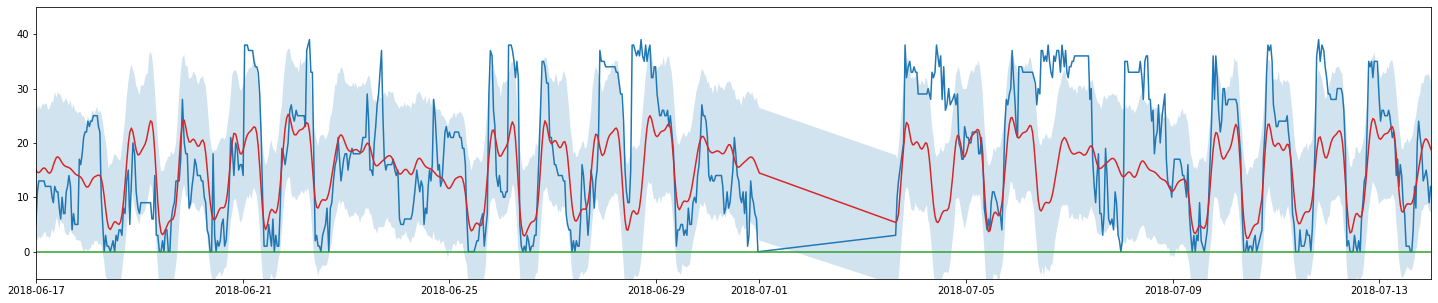

In [130]:
forcast_year_ts = forcast.set_index('ds')
true_year_ts = availbikes.set_index('ds')

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
#ax.plot(test_ts,label='test')
ax.plot(true_year_ts,label='train')
ax.plot(forcast_year_ts.yhat,label='forcast')
ax.fill_between(forcast_year_ts.index,forcast_year_ts.yhat_lower,forcast_year_ts.yhat_upper,alpha=0.2)
plt.axis([np.datetime64('2018-06-17'),np.datetime64('2018-07-14'),-5,45])

In [131]:
train_rmse = mean_squared_error(y_true=true_year_ts.y,
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],
                   squared=False)

# test_rmse = mean_squared_error(y_true=true_year_ts.interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
#                                squared=False)

train_mae = mean_absolute_error(y_true=true_year_ts.y,
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],)

# test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

# print(f'Test RMSE: {test_rmse}')
# print(f'Test MAE:  {test_mae}')

Train RMSE: 9.35101836267004
Train MAE:  7.654729999792475

